In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

In [102]:
df = pd.read_csv('LeagueData.csv')
df = df[df['league'].isin(['MSI'])]

C:\Users\Rajee\AppData\Local\Temp\ipykernel_24496\1580128714.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [103]:
df["kda"] = (df["kills"] + df["assists"]) / df["deaths"].replace(0, np.nan)
if "damageshare" in df.columns:
    df["dmg_pct"] = df["damageshare"] * 100
else:
    df["dmg_pct"] = np.nan

In [ ]:
df.shape

(960, 166)

In [ ]:
df.columns.tolist()

['gameid',
 'datacompleteness',
 'url',
 'league',
 'year',
 'split',
 'playoffs',
 'date',
 'game',
 'patch',
 'participantid',
 'side',
 'position',
 'playername',
 'playerid',
 'teamname',
 'teamid',
 'champion',
 'ban1',
 'ban2',
 'ban3',
 'ban4',
 'ban5',
 'pick1',
 'pick2',
 'pick3',
 'pick4',
 'pick5',
 'gamelength',
 'result',
 'kills',
 'deaths',
 'assists',
 'teamkills',
 'teamdeaths',
 'doublekills',
 'triplekills',
 'quadrakills',
 'pentakills',
 'firstblood',
 'firstbloodkill',
 'firstbloodassist',
 'firstbloodvictim',
 'team kpm',
 'ckpm',
 'firstdragon',
 'dragons',
 'opp_dragons',
 'elementaldrakes',
 'opp_elementaldrakes',
 'infernals',
 'mountains',
 'clouds',
 'oceans',
 'chemtechs',
 'hextechs',
 'dragons (type unknown)',
 'elders',
 'opp_elders',
 'firstherald',
 'heralds',
 'opp_heralds',
 'void_grubs',
 'opp_void_grubs',
 'firstbaron',
 'barons',
 'opp_barons',
 'atakhans',
 'opp_atakhans',
 'firsttower',
 'towers',
 'opp_towers',
 'firstmidtower',
 'firsttothree

In [ ]:
df["teamname"].value_counts().head(25)

teamname
T1                    138
Bilibili Gaming       126
Anyone's Legend       126
G2 Esports            120
Gen.G                 114
GAM Esports            78
CTBC Flying Oyster     78
FlyQuest               72
FURIA                  60
Movistar KOI           48
Name: count, dtype: int64

In [107]:
stats_cols = [
    "dpm",
    "cspm",
    "earned gpm",
    "golddiffat15",
    "csdiffat15",
    "xpdiffat15",
    "kda",
    "dmg_pct"
]
labels = [
    "DPM",
    "CSM",
    "GPM",
    "GD@15",
    "CSD@15",
    "XPD@15",
    "KDA",
    "DMG%"
]

In [ ]:
player_stats = df.groupby(["playername", "teamname", "position"])[stats_cols].mean().reset_index()

role_avg = player_stats.groupby('position')[stats_cols].mean()
role_mins = player_stats.groupby("position")[stats_cols].min()
role_maxs = player_stats.groupby("position")[stats_cols].max()

role_avg_normed = (role_avg - role_mins) / (role_maxs - role_mins)

In [ ]:
def make_radar(ax, values, role, categories, label, raw_values=None, color="orange", avg_color="red"):
    avg_values_normed = role_avg_normed.loc[role].values
    player_values_normed = values

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    player_vals_plot = np.concatenate([player_values_normed, [player_values_normed[0]]])
    avg_vals_plot = np.concatenate([avg_values_normed, [avg_values_normed[0]]])
    
    ax.plot(angles, player_vals_plot, color=color, linewidth=2, label='Player')
    ax.fill(angles, player_vals_plot, color=color, alpha=0.25)

    ax.plot(angles, avg_vals_plot, color=avg_color, linewidth=2, linestyle="dashed", label='Role Avg')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_ylim(0, 1) 

    if raw_values is not None:
        tick_labels = [f"{cat}\n{val:.1f}" for cat, val in zip(categories, raw_values)]
    else:
        tick_labels = categories
    ax.set_xticklabels(tick_labels, size=8)
    ax.set_yticklabels([])
    ax.set_title(label, size=11, pad=15, color="white")
    ax.grid(color="#555555")
    ax.spines["polar"].set_color("#555555")
    ax.tick_params(colors='white')
    ax.set_xticklabels(tick_labels, size=8, color="white")

    for lbl in ax.get_xticklabels():
        lbl.set_horizontalalignment("center")
        lbl.set_verticalalignment("center")
        lbl.set_y(lbl.get_position()[1] - 0.075)
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=7, labelcolor='white')

In [ ]:
def plot_role_radars(role="mid", max_players=9, theme=None):
    if theme is None:
        theme = {
            "bg_color": "#262626",
            "text_color": "#e0e0e0", 
            "player_color": "#00c2ff",
            "avg_color": "#FF0000"
        }
    
    data = player_stats[player_stats["position"] == role].copy()
    
    role = data["position"].iloc[0]
    normed = (data[stats_cols] - role_mins.loc[role]) / (role_maxs.loc[role] - role_mins.loc[role])

    normed["score"] = normed.mean(axis=1)
    data = data.assign(score=normed["score"]).sort_values("score", ascending=False).head(max_players)
    normed = normed.loc[data.index]

    n = len(data)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, subplot_kw=dict(polar=True), 
                            figsize=(cols*4.5, rows*4.5))
    
    if rows == 1:
        axes = [axes]
    axes = axes.flatten()
    
    fig.patch.set_facecolor(theme["bg_color"])
    fig.suptitle(f"{role.upper()} - Role Performance Radar", fontsize=20, 
                color=theme["text_color"], y=1.025)
    
    for i, (idx, row) in enumerate(data.iterrows()):
        player_values_normed = normed.loc[idx, stats_cols].values
        raw_values = row[stats_cols].values
        display_name = f"{row['playername']}\n({row['teamname']})"
        
        make_radar(
            axes[i],
            player_values_normed,
            role,
            labels,
            label=display_name,
            raw_values=raw_values,
            color=theme["player_color"],
            avg_color=theme["avg_color"]
        )

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [ ]:
dark_theme = {
    "bg_color": "#262626",
    "text_color": "#e0e0e0",
    "player_color": "#00c2ff",
    "avg_color": "#FF0000"
}

In [112]:
plt.rcParams.update({
    "axes.facecolor": dark_theme["bg_color"],
    "figure.facecolor": dark_theme["bg_color"],
    "axes.edgecolor": dark_theme["text_color"],
    "axes.labelcolor": dark_theme["text_color"],
    "xtick.color": dark_theme["text_color"],
    "ytick.color": dark_theme["text_color"],
    "text.color": dark_theme["text_color"],
    "axes.titlecolor": dark_theme["text_color"],
    "grid.color": "#555555"
})

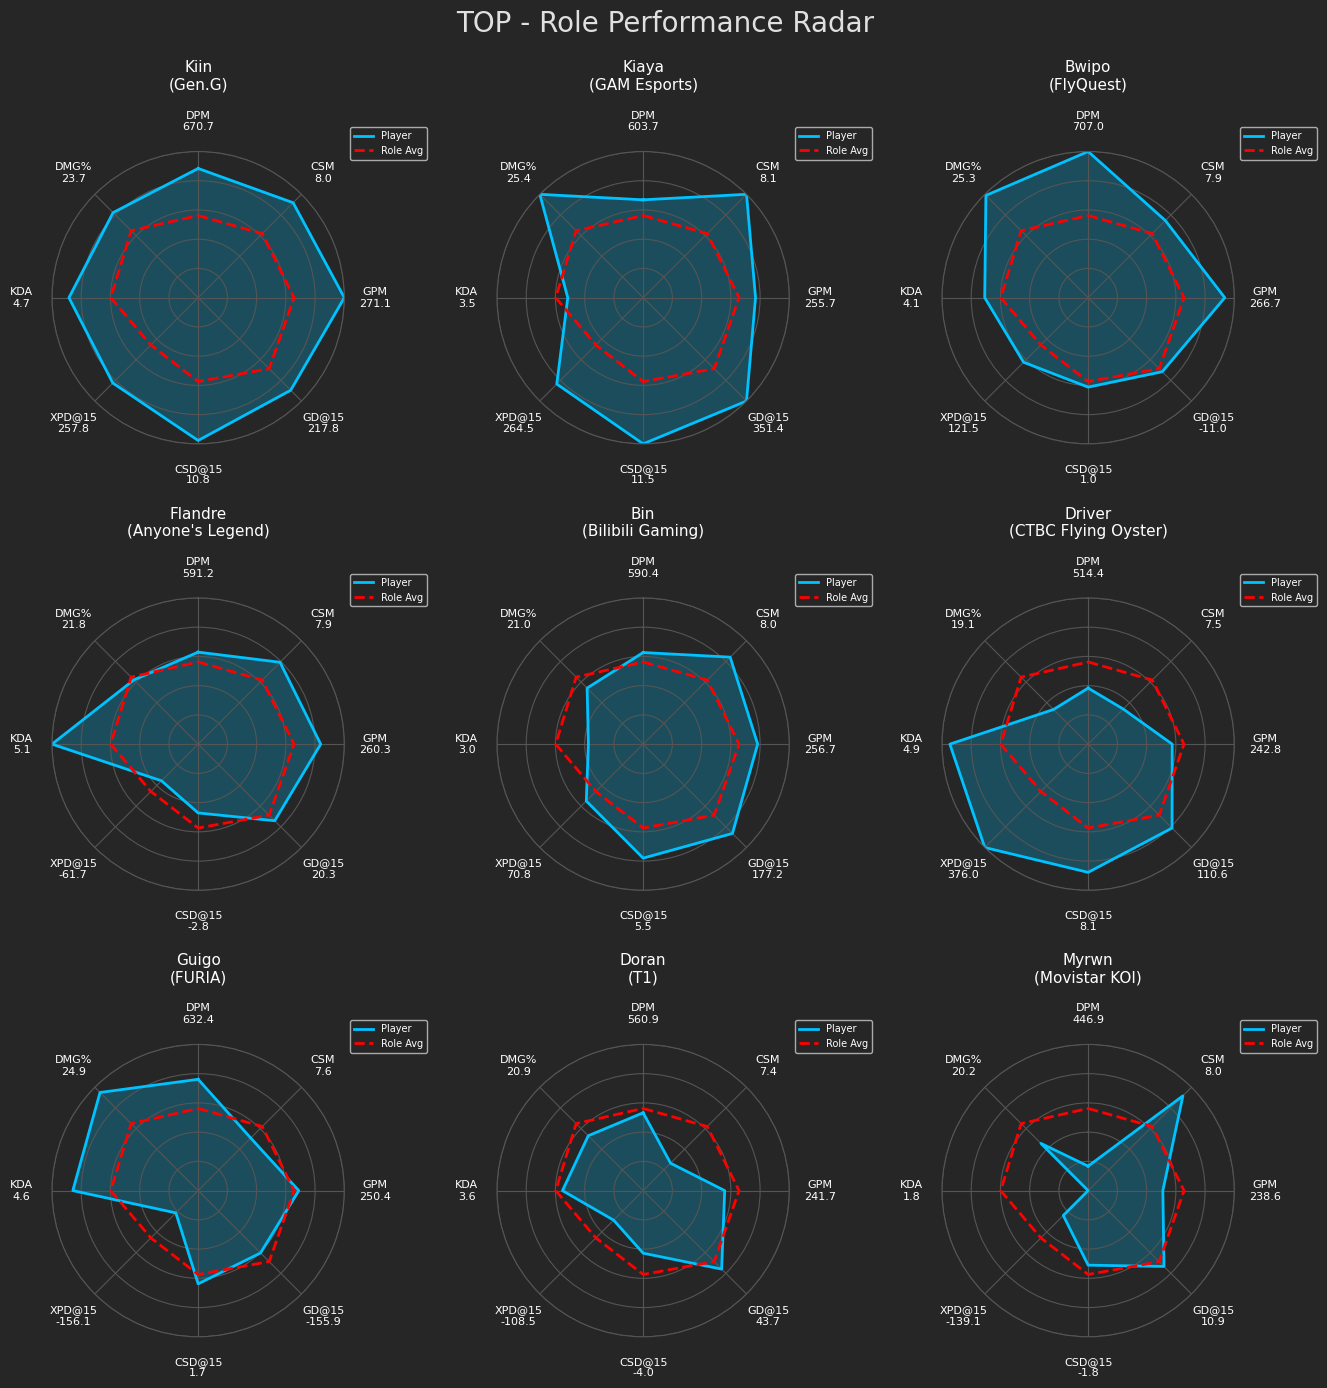

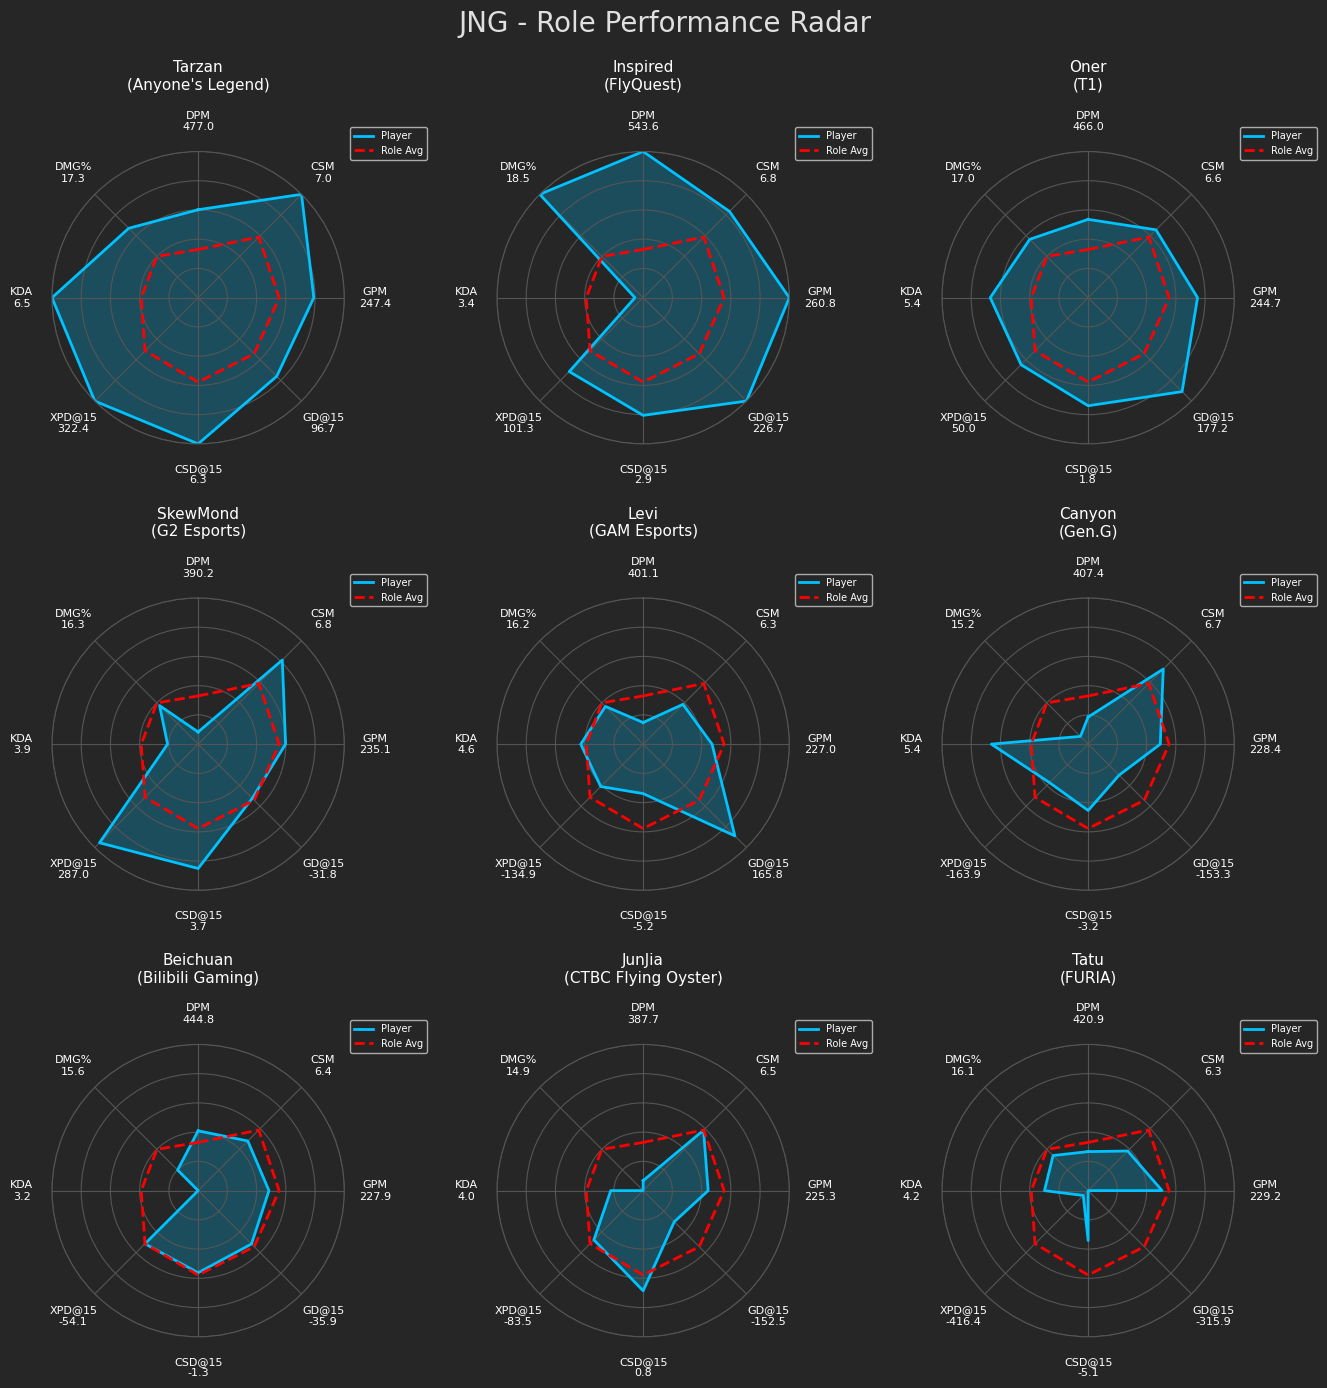

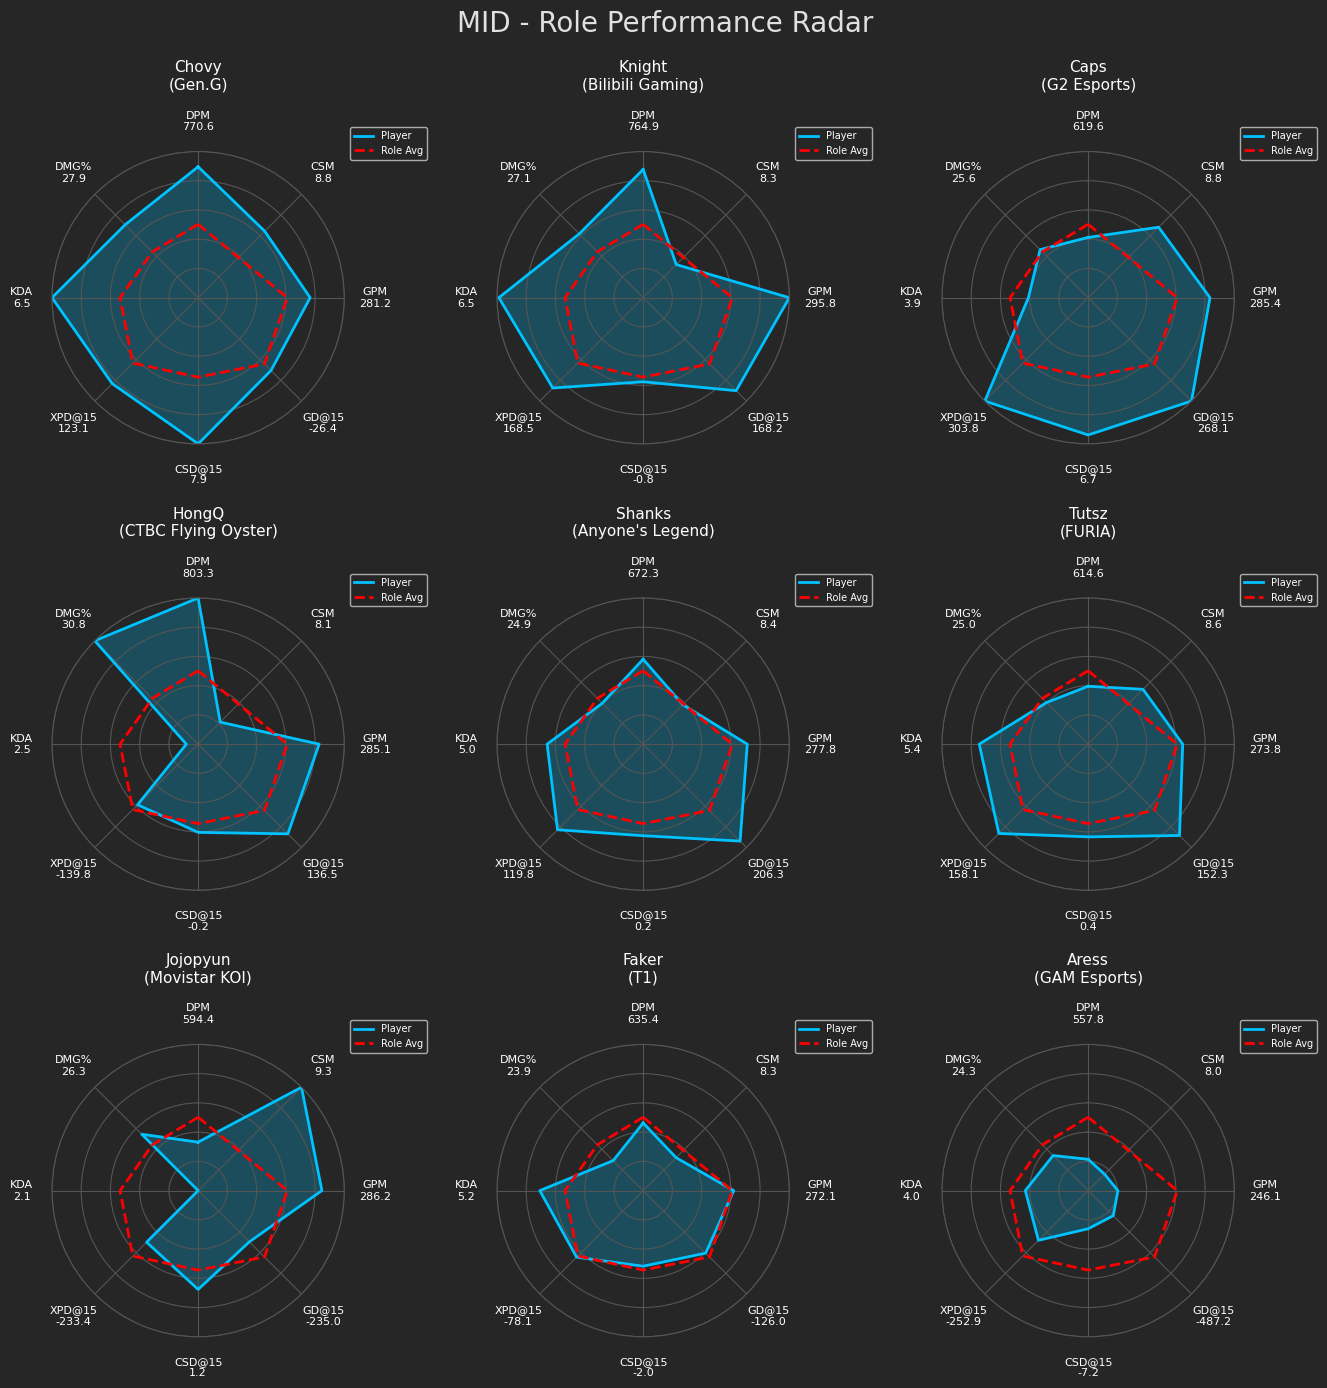

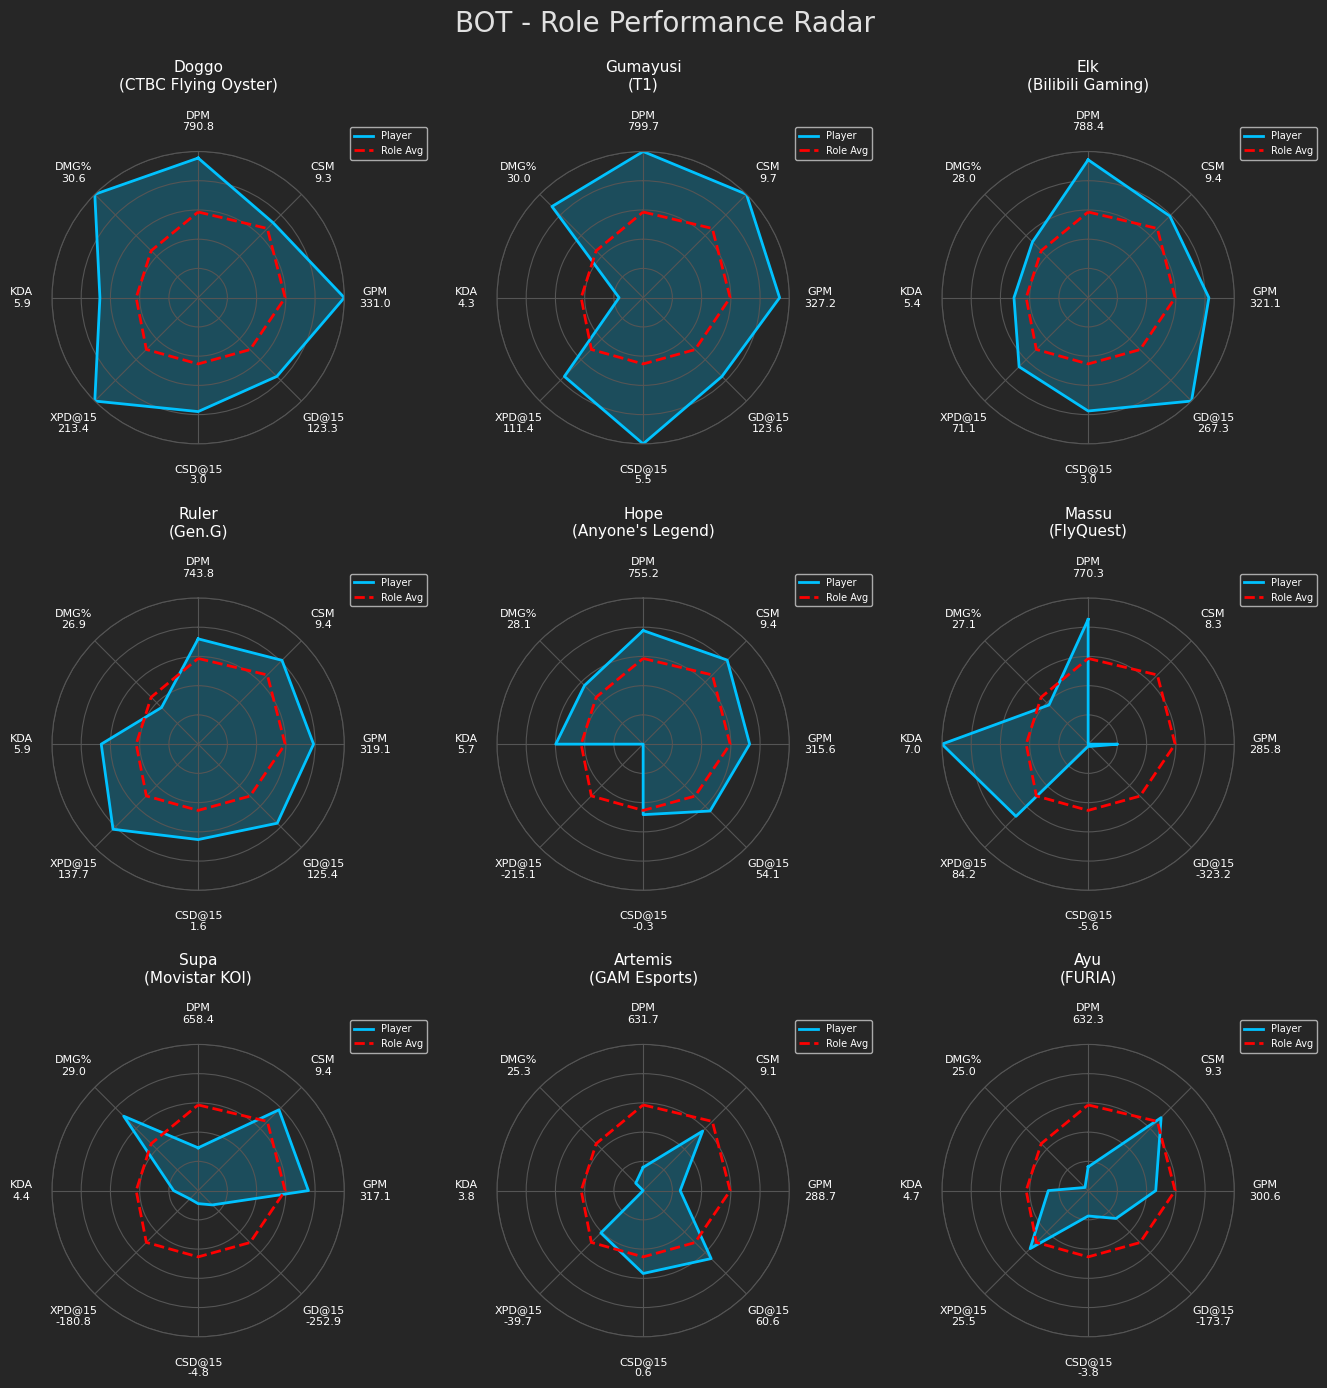

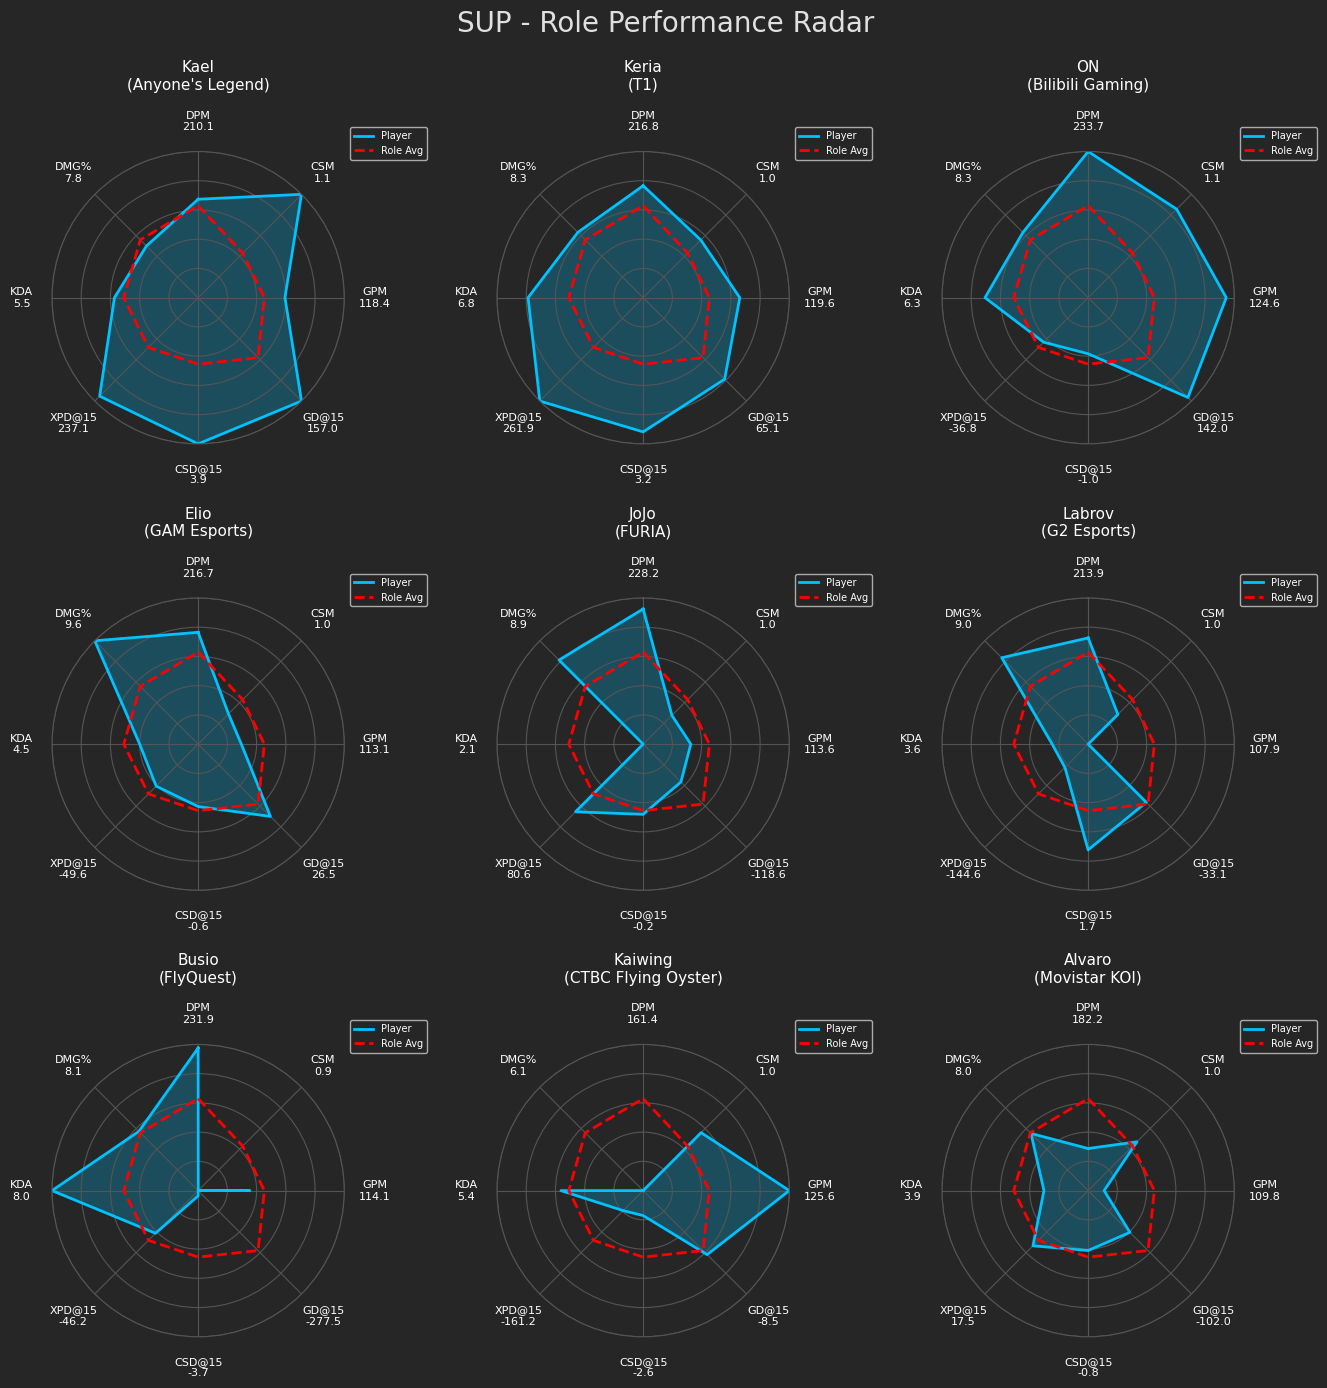

In [113]:
plot_role_radars("top", max_players=9, theme=dark_theme)
plot_role_radars("jng", max_players=9, theme=dark_theme)
plot_role_radars("mid", max_players=9, theme=dark_theme)
plot_role_radars("bot", max_players=9, theme=dark_theme)
plot_role_radars("sup", max_players=9, theme=dark_theme)

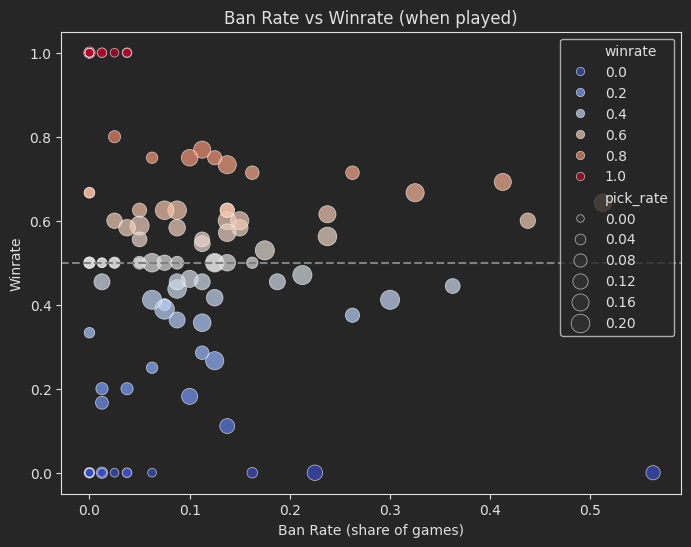

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ban_cols = ["ban1","ban2","ban3","ban4","ban5"]
ban_df = df[["gameid","teamid"] + ban_cols].drop_duplicates()
ban_series = pd.melt(ban_df, id_vars=["gameid","teamid"], value_vars=ban_cols, value_name="champion")["champion"]
ban_counts = ban_series.value_counts()

pick_counts = df["champion"].value_counts()

champ_wr = df.groupby("champion")["result"].mean()

champ_meta = pd.DataFrame({
    "ban_count": ban_counts,
    "pick_count": pick_counts,
    "winrate": champ_wr
}).fillna(0)

champ_meta["ban_rate"] = champ_meta["ban_count"] / ban_df["gameid"].nunique()
champ_meta["pick_rate"] = champ_meta["pick_count"] / df["gameid"].nunique()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=champ_meta, 
    x="ban_rate", y="winrate", size="pick_rate",
    hue="winrate", palette="coolwarm", sizes=(30,200), alpha=0.7
)
plt.axhline(0.5, ls="--", color="gray")
plt.title("Ban Rate vs Winrate (when played)")
plt.xlabel("Ban Rate (share of games)")
plt.ylabel("Winrate")
plt.show()



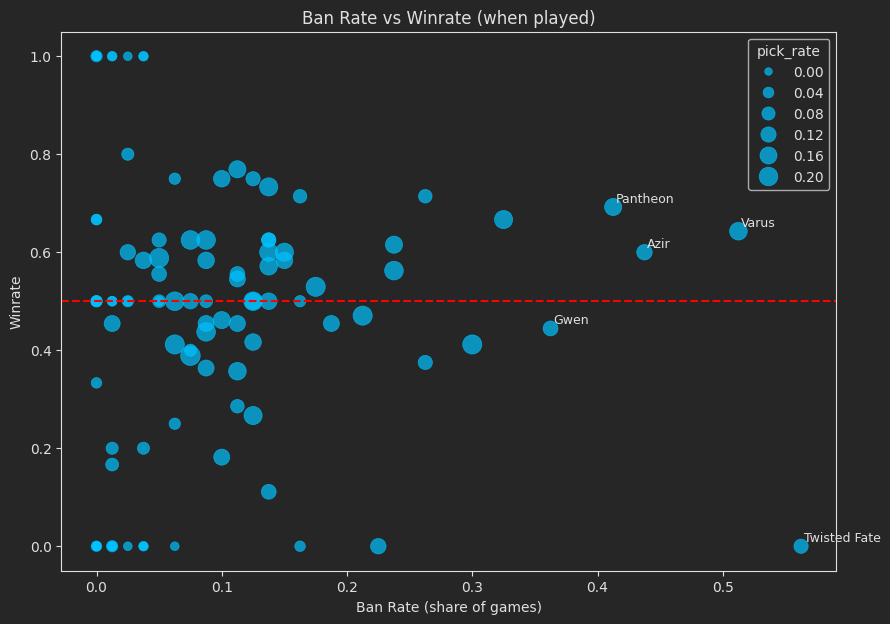

In [ ]:
plt.figure(figsize=(10,7))

ax = sns.scatterplot(
    data=champ_meta, 
    x="ban_rate", y="winrate", size="pick_rate",
    color=dark_theme["player_color"], sizes=(30,200), alpha=0.7, edgecolor=None
)

plt.axhline(0.5, ls="--", color=dark_theme["avg_color"])

plt.title("Ban Rate vs Winrate (when played)", color=dark_theme["text_color"])
plt.xlabel("Ban Rate (share of games)", color=dark_theme["text_color"])
plt.ylabel("Winrate", color=dark_theme["text_color"])

ax.set_facecolor(dark_theme["bg_color"])
plt.gcf().set_facecolor(dark_theme["bg_color"])

top_banned = champ_meta.sort_values("ban_count", ascending=False).head(5)
top_wr = champ_meta[champ_meta["pick_count"] > 20].sort_values("winrate", ascending=False).head(5)
notables = pd.concat([top_banned, top_wr])

for champ, row in notables.iterrows():
    ax.text(
        row["ban_rate"]+0.002, row["winrate"]+0.01, champ,
        fontsize=9, color=dark_theme["text_color"]
    )

plt.xticks(color=dark_theme["text_color"])
plt.yticks(color=dark_theme["text_color"])

plt.show()


In [ ]:
import plotly.express as px

fig = px.scatter(
    champ_meta.reset_index(),
    x="ban_rate",
    y="winrate",
    size="pick_rate",
    color="winrate",
    hover_name="champion",
    hover_data={
        "ban_rate":":.2%",
        "pick_rate":":.2%",
        "ban_count":True,
        "pick_count":True,
        "winrate":":.1%",
    },
    size_max=40,
    color_continuous_scale="RdYlBu",
    title="Ban Rate vs Winrate (Hover for Champion Details)"
)

fig.add_hline(y=0.5, line_dash="dash", line_color="gray")

fig.update_layout(
    xaxis_title="Ban Rate (share of games)",
    yaxis_title="Winrate",
    legend_title="Winrate",
    template="plotly_white"
)

fig.show()


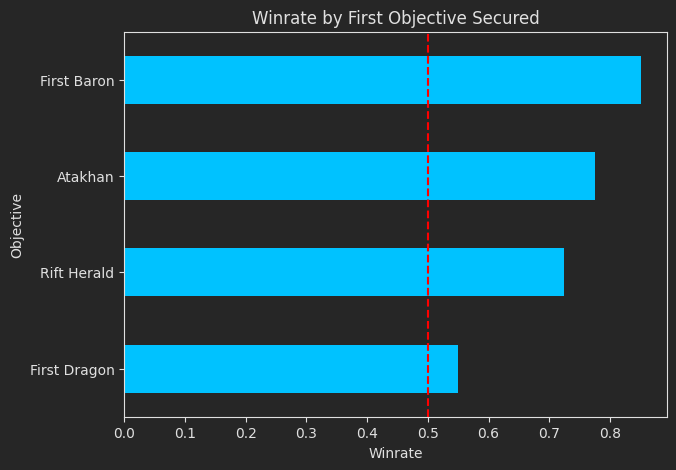

In [ ]:
objectives = ["firstdragon","firstherald","firstbaron","atakhans"]

obj_labels = {
    "firstdragon": "First Dragon",
    "firstherald": "Rift Herald",
    "firstbaron": "First Baron",
    "atakhans": "Atakhan",
}
obj_wr = {obj: df.groupby(obj)["result"].mean()[1] for obj in objectives}

obj_wr = pd.Series(obj_wr)
plt.figure(figsize=(7,5))
obj_wr.index = [obj_labels[obj] for obj in obj_wr.index]
obj_wr.sort_values().plot(kind="barh", color="#00c2ff")
plt.axvline(0.5, ls="--", color="#FF0000")
plt.title("Winrate by First Objective Secured")
plt.xlabel("Winrate")
plt.ylabel("Objective")
plt.show()


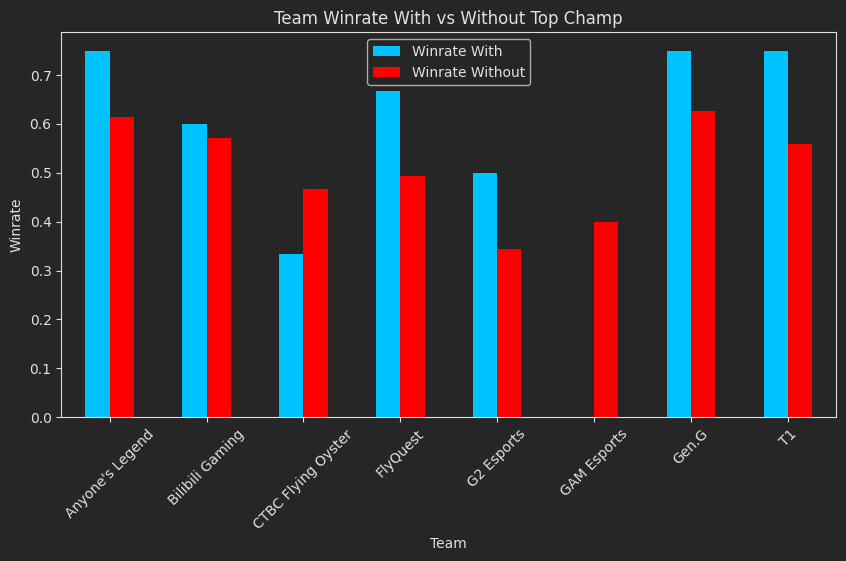

In [ ]:
team_champ_counts = df.groupby(["teamname","champion"]).size()
team_top_champs = team_champ_counts.groupby("teamname").idxmax().apply(lambda x: x[1])

team_reliance = []
for team, champ in team_top_champs.items():
    with_champ = df[(df["teamname"]==team) & (df["champion"]==champ)]["result"].mean()
    without_champ = df[(df["teamname"]==team) & (df["champion"]!=champ)]["result"].mean()
    team_reliance.append([team, champ, with_champ, without_champ])

team_reliance = pd.DataFrame(team_reliance, columns=["Team","Top Champ","Winrate With","Winrate Without"])

top_teams = df["teamname"].value_counts().head(8).index
team_reliance_top = team_reliance[team_reliance["Team"].isin(top_teams)]

ax = team_reliance_top.set_index("Team")[["Winrate With","Winrate Without"]].plot(
    kind="bar",
    figsize=(10,5),
    color=[dark_theme["player_color"], dark_theme["avg_color"]]
)

plt.title("Team Winrate With vs Without Top Champ", color=dark_theme["text_color"])
plt.ylabel("Winrate", color=dark_theme["text_color"])
ax.set_facecolor(dark_theme["bg_color"])
plt.xticks(rotation=45, color=dark_theme["text_color"])
plt.yticks(color=dark_theme["text_color"])
plt.show()



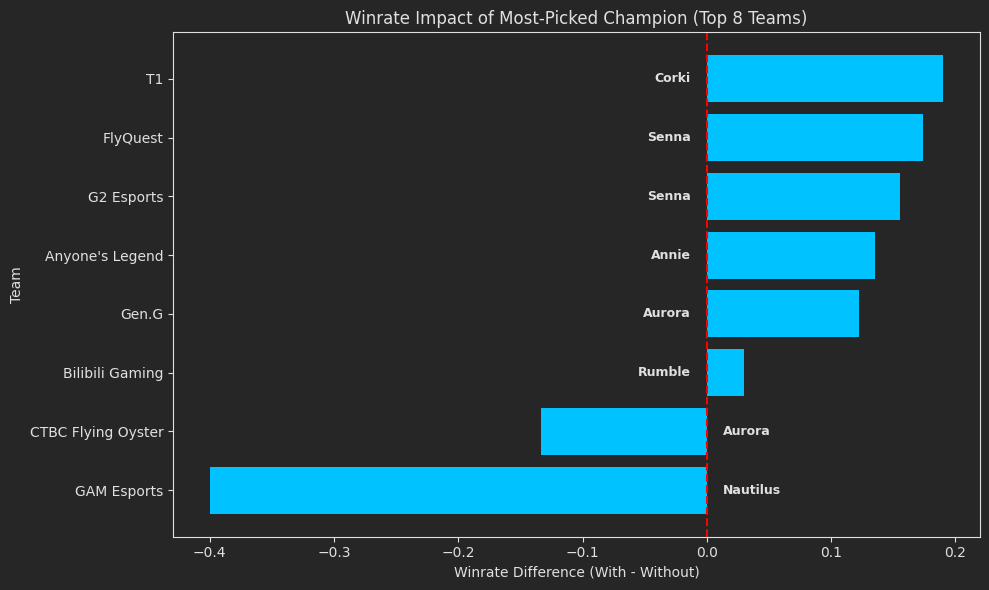

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

dark_theme = {
    "bg_color": "#262626",
    "text_color": "#e0e0e0",
    "player_color": "#00c2ff",
    "avg_color": "#FF0000"
}

team_champ_counts = df.groupby(["teamname", "champion"]).size()
team_top_champs = team_champ_counts.groupby("teamname").idxmax().apply(lambda x: x[1])

team_reliance = []
for team, champ in team_top_champs.items():
    with_champ = df[(df["teamname"] == team) & (df["champion"] == champ)]["result"].mean()
    without_champ = df[(df["teamname"] == team) & (df["champion"] != champ)]["result"].mean()
    team_reliance.append([team, champ, with_champ, without_champ])

team_reliance = pd.DataFrame(team_reliance, columns=["Team", "Top Champ", "Winrate With", "Winrate Without"])
team_reliance["WR Diff"] = team_reliance["Winrate With"] - team_reliance["Winrate Without"]

top_teams = df["teamname"].value_counts().head(8).index
team_reliance_top = team_reliance[team_reliance["Team"].isin(top_teams)].sort_values("WR Diff")

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor(dark_theme["bg_color"])
ax.set_facecolor(dark_theme["bg_color"])

bars = ax.barh(team_reliance_top["Team"], team_reliance_top["WR Diff"], color=dark_theme["player_color"], edgecolor="none")

ax.axvline(0, color=dark_theme["avg_color"], linestyle="--", linewidth=1.5)

ax.set_title("Winrate Impact of Most-Picked Champion (Top 8 Teams)", color=dark_theme["text_color"])
ax.set_xlabel("Winrate Difference (With - Without)", color=dark_theme["text_color"])
ax.set_ylabel("Team", color=dark_theme["text_color"])

ax.tick_params(colors=dark_theme["text_color"])
for spine in ax.spines.values():
    spine.set_color(dark_theme["text_color"])

x_min, x_max = ax.get_xlim()
offset = max((x_max - x_min) * 0.02, 0.01)

for bar, champ, wr_diff in zip(bars, team_reliance_top["Top Champ"], team_reliance_top["WR Diff"]):
    y = bar.get_y() + bar.get_height() / 2
    if wr_diff >= 0:
        x_pos = 0 - offset
        ha = "right"
    else:
        x_pos = 0 + offset
        ha = "left"

    ax.text(x_pos, y, champ, va="center", ha=ha, fontsize=9,
            color=dark_theme["text_color"], fontweight="bold")

label_xs = [(-offset if wr >= 0 else offset) for wr in team_reliance_top["WR Diff"]]
new_x_min = min(x_min, min(label_xs) - offset * 1.2)
new_x_max = max(x_max, max(label_xs) + offset * 1.2)
ax.set_xlim(new_x_min, new_x_max)

plt.tight_layout()
plt.show()


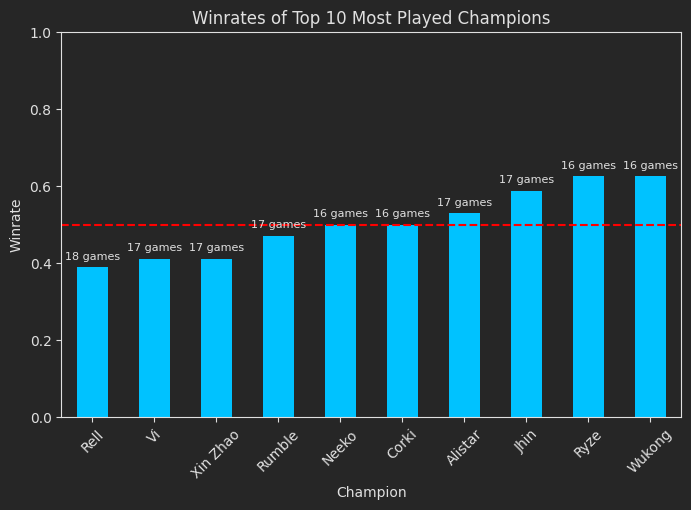

In [ ]:
top_champs = df["champion"].value_counts().head(10).index
top_champ_stats = df[df["champion"].isin(top_champs)].groupby("champion")["result"].mean().sort_values()
plt.figure(figsize=(8,5))
top_champ_stats.plot(kind="bar", color=dark_theme["player_color"], edgecolor="none")
for i, champ in enumerate(top_champ_stats.index):
    count = df[df["champion"]==champ].shape[0]
    plt.text(i, top_champ_stats[champ]+0.02, f"{count} games", ha="center", color=dark_theme["text_color"], fontsize=8)

plt.title("Winrates of Top 10 Most Played Champions")
plt.xlabel("Champion")
plt.ylabel("Winrate")
plt.ylim(0,1)
plt.axhline(0.5, ls="--", color=dark_theme["avg_color"])
plt.xticks(rotation=45)
plt.show()